In [17]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from scipy.sparse import csr_matrix

In [2]:
#!pip install hdbscan-0.8.28-cp39-cp39-win_amd64.whl
#!pip install top2vec
#!pip install spacy

In [2]:
#train=pd.read_csv('train.csv')
#test=pd.read_csv('test.csv')

train=pd.read_csv('train_finished.csv')
test=pd.read_csv('test_finished.csv')
df_label=pd.read_pickle('df_label.pickle')

train.head()

,id,keyword,location,text,target,city,length,word_cnt,avg_word_len,lon,...,month2,day1,day2,clean_location,location_lon,location_lat,keyword_token,longest_tag,longest_hashtag,hashtag_token
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,69,13,4.384615,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,[,earthquake,4
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,38,7,4.571429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,[,NaN,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,133,22,5.090909,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,[,NaN,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,California,65,8,7.125000,-118.755997,...,NaN,NaN,NaN,NaN,NaN,NaN,0,[,wildfires,77
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Alaska,88,16,4.500000,-149.680909,...,NaN,NaN,NaN,NaN,NaN,NaN,0,[,wildfires,77


# take a look into the data

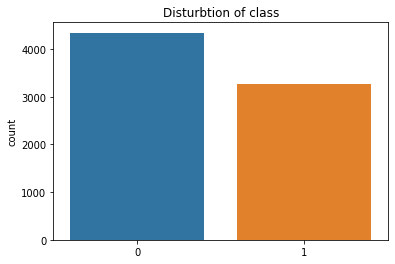

In [3]:
import plotly.express as px
import plotly.graph_objects as go

#px.bar(train['target'].value_counts(),title="",labels={'value':'count'})
sns.barplot(y=train['target'].value_counts().values,x=train['target'].value_counts().index)
plt.ylabel('count')
plt.title('Disturbtion of class')
plt.show()

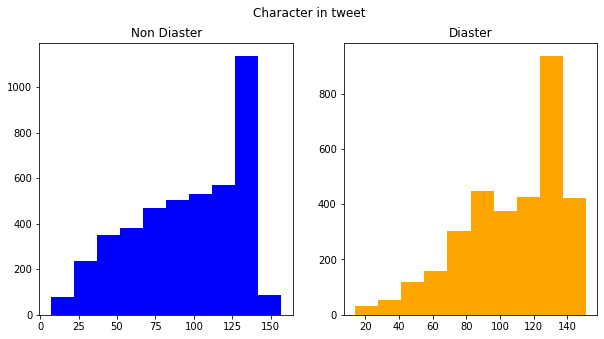

In [4]:
char0=train[train['target']==0]['text'].str.len()
char1=train[train['target']==1]['text'].str.len()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(char0,color='blue')
ax1.set_title('Non Diaster')

ax2.hist(char1,color='orange')
ax2.set_title('Diaster')

fig.suptitle('Character in tweet')
plt.show()

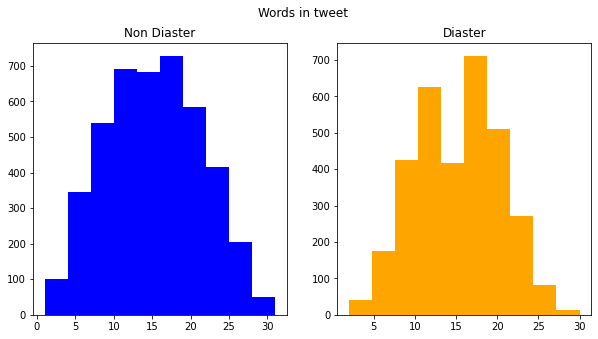

In [5]:
word0=train[train['target']==0]['text'].str.split().apply(len)
word1=train[train['target']==1]['text'].str.split().apply(len)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(word0,color='blue')
ax1.set_title('Non Diaster')

ax2.hist(word1,color='orange')
ax2.set_title('Diaster')

fig.suptitle('Words in tweet')
plt.show()

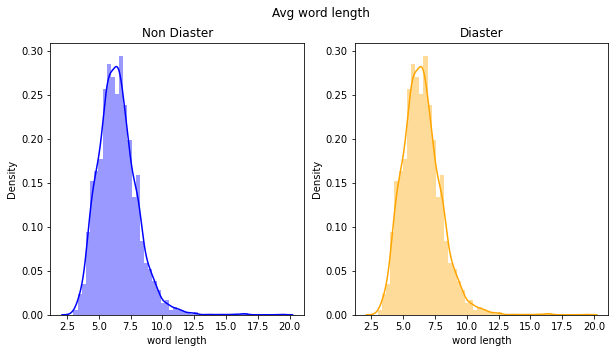

In [6]:
#得一個value show trend就要用dist plt
len_word1=train[train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
x1=len_word1.map(lambda x : np.mean(x))

len_word0=train[train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
x0=len_word0.map(lambda x : np.mean(x))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

sns.distplot(x0,ax=ax1,color='blue')
ax1.set_title('Non Diaster')
ax1.set_xlabel('word length')

sns.distplot(x1,ax=ax2,color='orange')
ax2.set_title('Diaster')
ax2.set_xlabel('word length')

fig.suptitle('Avg word length')

plt.show()                          

# adding features

In [182]:
full_data=[train,test]

for df in full_data:
    df['length']=df.text.str.len()
    df['word_cnt']=df.text.str.split().apply(len)
    word_len=df.text.str.split().apply(lambda x:[len(i) for i in x])
    df['avg_word_len']=word_len.map(lambda x:np.mean(x))

In [66]:
train.head()

,id,keyword,location,text,target,length,word_cnt,avg_word_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000


# locations

In [ ]:
#!pip install spacy-download

In [8]:
import spacy
from spacy import displacy

from spacy_download import load_spacy

nlp = load_spacy('xx_ent_wiki_sm')
#refernce 
#https://medium.com/spatial-data-science/how-to-extract-locations-from-text-with-natural-language-processing-9b77035b3ea4

In [9]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
def parse_text(text):
    #print(f'Input: {text}')

    text = re.sub("[^a-zA-Z]", ' ', text)
    #print(f'Remove punctuation and numbers: {text}')

    text = text.lower().split()
    #print(f'Lowercase and split: {text}')

    swords = set(stopwords.words("english"))
    text = [w for w in text if w not in swords]
    #print(f'Remove stop words: {text}')
    
    text = " ".join(text)
    #print(f'Final: {text}')
    
    text = text.replace(' https ',' ')
    text = text.replace(' http ',' ')

    return text

### remove stop word

In [11]:
tr_clean_text=train.text.apply(parse_text)
te_clean_text=test.text.apply(parse_text)

In [112]:
#!pip install locationtagger

In [8]:
import spacy
from spacy import displacy
from spacy_download import load_spacy
nlp = load_spacy('xx_ent_wiki_sm')

import nltk
nltk.downloader.download('maxent_ne_chunker')
nltk.downloader.download('words')
nltk.downloader.download('treebank')
nltk.downloader.download('maxent_treebank_pos_tagger')
nltk.downloader.download('punkt')
nltk.download('averaged_perceptron_tagger')

import locationtagger



[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package

In [13]:
import locationtagger
def find_location(text_series):
    cities=pd.Series(np.nan,index=range(0,len(text_series)))
    series=text_series[text_series==text_series]
    
    for n,texts in zip(series.index,series):
        #loc_list=[]
        #doc=nlp(text)
        #for word in doc.ents:
        #    if word.label_ in ['LOC']:
        #        loc_list.append(word.text)
        #        loc=' '.join(loc_list)
        if len(texts)>0:
            tagger=locationtagger.find_locations(text=texts)
            city=tagger.cities
            if len(city)>0:
                cities[n]=city[0]
            elif len(city)==0:
                region=tagger.regions
                if len(region)>0:
                    cities[n]=region[0]
                elif len(region)==0:
                    country=tagger.countries
                    if len(country)>0:
                        cities[n]=country[0]
                        
    return cities

In [16]:
#refernce 
#https://www.geeksforgeeks.org/extracting-locations-from-text-using-python/
'''
# initializing sample text
sample_text = ["has very rich and vivid culture", 
               "spread from Kerala to Nagaland to Haryana to Maharashtra. " ]
# extracting entities.
place_entity = locationtagger.find_locations(text=sample_text)

# getting all places
print(place_entity.countries)

print(place_entity.regions)

print(place_entity.cities)
'''


train['city']=find_location(tr_clean_text)
test['city']=find_location(te_clean_text)

In [17]:
#tr_clean_location=train.location.apply(parse_text)
#te_clean_location=test.location.apply(parse_text)

train['clean_location']=find_location(train['location'])
test['clean_location']=find_location(test['location'])

In [ ]:
train.info()

In [183]:
#!pip install geopy

In [2]:
from geopy.geocoders import Nominatim
from time import sleep
from random import randint
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

def lon_lat_locator(series,sleep_sec):
    user_agent = 'user_me_{}'.format(randint(10000,99999))
    geolocator = Nominatim(user_agent=user_agent)
    
    lon=series.copy()
    lat=series.copy()
    
    cities=series[series==series]
    cities=cities.unique()
    list_lon=[]
    list_lat=[]
    
    for city in cities:
        try:
            locator=geolocator.geocode(city)
            list_lon.append(locator.longitude)
        except AttributeError:
            list_lon.append(np.nan)
            list_lat.append(np.nan)
        except GeocoderTimedOut:
            logging.info('TIMED OUT: GeocoderTimedOut: Retrying...')
            sleep(randint(1*100,sleep_sec*100)/100)
            list_lon.append(locator.longitude)
            list_lat.append(locator.latitude)
        except:
            list_lon.append('error')
            list_lat.append('error')
        else:
            list_lat.append(locator.latitude)
            
    lon=lon.replace(to_replace=cities,value=list_lon)
    lat=lat.replace(to_replace=cities,value=list_lat)
            
    return lon,lat


In [40]:
train['lon'],train['lat']=lon_lat_locator(train['city'])
test['lon'],test['lat']=lon_lat_locator(test['city'])

In [59]:
len(train['location_lon'][train['location_lon']=='error'])

33

In [7]:
len(test['location_lon'][test['location_lon']=='error'])

11

In [54]:
train['location_lon'],train['location_lat']=lon_lat_locator(train['location'],5)
#test['location_lon'],test['location_lat']=lon_lat_locator(test['location'])

In [6]:
test['location_lon'],test['location_lat']=lon_lat_locator(test['location'],5)

# stop words features

In [185]:
train['non_stopwords']=tr_clean_text
test['non_stopwords']=te_clean_text

In [186]:
full_data=[train,test]

for df in full_data:
    df['NSW_length']=df.non_stopwords.str.len()
    df['NSW_word_cnt']=df.non_stopwords.str.split().apply(len)
    word_len=df.non_stopwords.str.split().apply(lambda x:[len(i) for i in x])
    df['NSW_avg_word_len']=word_len.map(lambda x:np.mean(x))

In [187]:
def parse_stopwords(text):
    #print(f'Input: {text}')

    text = re.sub("[^a-zA-Z]", ' ', text)
    #print(f'Remove punctuation and numbers: {text}')

    text = text.lower().split()
    #print(f'Lowercase and split: {text}')

    swords = set(stopwords.words("english"))
    text = [w for w in text if w in swords]
    #print(f'Remove stop words: {text}')
    
    text = " ".join(text)
    #print(f'Final: {text}')
    
    text = text.replace(' https ',' ')
    text = text.replace(' http ',' ')

    return text

In [190]:
tr_SW=train.text.apply(parse_stopwords)
te_SW=test.text.apply(parse_stopwords)

In [215]:
for df in full_data:
    SW=df.text.apply(parse_stopwords)
    df['SW_length']=SW.str.len()
    df['SW_word_cnt']=SW.str.split().apply(len)
    word_len=SW.str.split().apply(lambda x:[len(i) for i in x])
    df['SW_avg_word_len']=word_len.map(lambda x:np.mean(x))
    df['SW_unique_cnt']=SW.str.split().apply(set).apply(len)

In [216]:
train.head()


,id,keyword,location,text,target,city,length,word_cnt,avg_word_len,lon,lat,non_stopwords,NSW_length,NSW_word_cnt,NSW_avg_word_len,SW_length,SW_word_cnt,SW_avg_word_len,SW_unique_cnt
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,69,13,4.384615,NaN,NaN,deeds reason earthquake may allah forgive us,44,7,3.000000,23,6,3.000000,6
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,38,7,4.571429,NaN,NaN,forest fire near la ronge sask canada,37,7,NaN,0,0,NaN,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,133,22,5.090909,NaN,NaN,residents asked shelter place notified officer...,88,11,2.818182,41,11,2.818182,9
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,65,8,7.125000,NaN,NaN,people receive wildfires evacuation orders cal...,53,6,2.000000,2,1,2.000000,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,88,16,4.500000,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,55,9,3.285714,29,7,3.285714,6


# basic text poccess

In [3]:
full_data=[train,test]

for df in full_data:
    #df['text_length']=df['text'].apply(len)
    #df['sentence_no']=df.text.str.split('.').apply(len)
    #df['words_no']=df.text.str.split().apply(len)
    l=df.text.str.lower()
    df['unique_words']=l.str.split().apply(set).apply(len)
    
    # # @ digits /W
    hashtag=df.text.str.findall(r'#\w+')
    df['#']=hashtag
    df['#_no']=hashtag.apply(len)
    for n,token in enumerate(hashtag):
        df.loc[n,'#_len']=np.array([len(i) for i in token]).mean()
    #@
    attag=df.text.str.findall(r'@\w+')
    df['@']=attag
    df['@_no']=attag.apply(len)
    for n,token in enumerate(attag):
        df.loc[n,'@_len']=np.array([len(i) for i in token]).mean()
    #digits
    digits=df.text.str.findall('[0-9]')
    df['digit']=digits
    df['digit_no']=hashtag.apply(len)
    #\W
    nondigits=df.text.str.findall(r'\W+')
    df['nondigit']=nondigits.apply(set)
    df['nondigit_unique']=df['nondigit'].apply(len)
    df['nondigit_no']=nondigits.apply(len)
    
    
    

# DATE

In [267]:
def monthtonum(shortMonth):
    return {
            'jan': 1,
            'feb': 2,
            'mar': 3,
            'apr': 4,
            'may': 5,
            'jun': 6,
            'jul': 7,
            'aug': 8,
            'sep': 9, 
            'oct': 10,
            'nov': 11,
            'dec': 12
    }[shortMonth]

def date_sorter(df_series,verbose=True):
    import pandas as pd
    import re
    import numpy as np
    
    df=pd.DataFrame(df_series)
    text=df_series.str
    df['raw']=np.nan
    df['year1']=np.nan
    df['year2']=np.nan
    df['month1']=np.nan
    df['month2']=np.nan
    df['day1']=np.nan
    df['day2']=np.nan
    
    if verbose:
        print('text ready')
    #format 1a  yyyy
    #1c ?/?/yy = 1d yy/?/?
    
    format1a=r'\d?\d[-/]\d?\d[-/]\d\d\d\d'
    format1b=r'\d{1,2}[-/]\d{1,2}[/-]\d{2}'
    
    ia=[]
    ib=[]
    
    for n,x in enumerate(text.findall(format1a)):
        if len(x)>0:
            date=re.split(r'\W',x[0])
            if 2023>int(date[2])>1000:
                if int(date[1])>12:
                    month=int(date[0])
                    day=int(date[1])
                if int(date[0])>12:
                    month=int(date[1])
                    day=int(date[0])
                else:
                    month=int(date[0])
                    day=int(date[1])

                year=int(date[2])
            
            df.loc[n,'year1']=year
            df.loc[n,'month1']=month
            df.loc[n,'day1']=day
                
            ia.append(n)
                
    if verbose:
        print('f1a , {} converted'.format(len(ia)))

    for n,x in enumerate(text.findall(format1b)):
        if len(x)>0:
            for m in range(0,len(x)):                           
                date=re.split(r'\W',x[m])
                if int(date[2])>23:
                    year=1900+int(date[2])
                else: year=2000+int(date[2])

                if int(date[1])>12:
                    month=int(date[0])
                    day=int(date[1])
                if int(date[0])>12:
                    month=int(date[1])
                    day=int(date[0])
                else:
                    month=int(date[0])
                    day=int(date[1])

                df.loc[n,'year{}'.format(m+1)]=year
                df.loc[n,'month{}'.format(m+1)]=month
                df.loc[n,'day{}'.format(m+1)]=day
                
            ib.append(n)

    if verbose:
        print('f1a , {} converted'.format(len(ib)))

    format2a=format2a=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D{,3}|\w+)\D{1,2}\d?\d\D{1}\d\d\d\d'
    i2a=[]

    for n,x in enumerate(text.findall(format2a)):
        if len(x)>0:
            MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
            month=monthtonum(MMM)
            date=re.split(' ',x[0])
            year=int(date[-1])
            day=date[-2]

            if year<23:
                year+2000
            if year<100:
                year+1900
                
            df.loc[n,'year1']=int(year)
            df.loc[n,'month1']=int(month)
            df.loc[n,'day1']=int(day)
                
            i2a.append(n)

    if verbose:
        print('f2a , {} converted'.format(len(i2a)))
    
    format2b=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D{,3}|\w+)\D{1,2}\d?\d(?:\w{2}|\w\w\D)\d\d?\d?\d'
    i2b=[]

    for n,x in enumerate(text.findall(format2b)):
        if len(x)>0:
            MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
            month=monthtonum(MMM)
            
            date=re.split(' ',x[0])
            if len(date)==3:
                year=date[-1]
                day=re.findall(r'\d?\d',date[-2])[0]

            else:
                date=re.split(r'th|st|rd|nd',x[0])
                year=date[-1]
                day=re.findall(r'\d?\d',date[-2])[0]

            df.loc[n,'year1']=int(year)
            df.loc[n,'month1']=int(month)
            df.loc[n,'day1']=int(day)
                
            i2b.append(n)
        
    if verbose:
        print('f2b , {} converted'.format(len(i2b)))

    format3=r'\d?\d\D(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D|\w+\D)\d\d\d\d'
    i3=[]
    for n,x in enumerate(text.findall(format3)):
        if len(x)>0:
            MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
            month=monthtonum(MMM)

            date=re.split(r'[ -/]',x[0])
            if len(date)==3:
                year=date[-1]
                day=date[0]
                
            df.loc[n,'year1']=int(year)
            df.loc[n,'month1']=int(month)
            df.loc[n,'day1']=int(day)
            i3.append(n)
            
    if verbose:
        print('f3 , {} converted'.format(len(i3)))

    #Mar 20
    format4a=r'(?:Jan|Feb|March|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\D\d\d'
    i4a=[]
    for n,x in enumerate(text.findall(format4a)):
        if len(x)>0:
            if np.isnan(df.loc[n,'month1']) & np.isnan(df.loc[n,'day1']):
                MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
                month=monthtonum(MMM)
                
                day=re.findall(r'\d?\d',x[0])[0]
                
                df.loc[n,'month1']=int(month)
                df.loc[n,'day1']=int(day)
                
                i4a.append(n)
    if verbose:
        print('f4a , {} converted'.format(len(i4a)))
        
    format4b=r'\d?\d\D(?:Jan|Feb|March|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)'
    i4b=[]
    for n,x in enumerate(text.findall(format4b)):
        if len(x)>0:
            if np.isnan(df.loc[n,'month1']) & np.isnan(df.loc[n,'day1']):
                MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
                month=monthtonum(MMM)
                
                day=re.findall(r'\d?\d',x[0])[0]
                
                df.loc[n,'month1']=int(month)
                df.loc[n,'day1']=int(day)
                
                i4b.append(n)
    if verbose:
        print('f4b , {} converted'.format(len(i4b)))

        #    Feb 2009; Sep 2009; Oct 2010
    format5=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\D+\d{4}'
    i5=[]

    #check if nan in ['date']
    #using pd.isnull(df['date'][n])
    for n,x in enumerate(text.findall(format5)):
        if len(x)>0:
            if np.isnan(df.loc[n,'month1']) & np.isnan(df.loc[n,'year1']):
                date=re.split(r'[ -/]',x[0])
                if len(date)<5:
                    yyyy=int(re.findall(r'\d\d\d\d',x[0])[0])
                    if 2023>yyyy>1000: 
                        MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
                        month=monthtonum(MMM)    
                        year=yyyy

                        df.loc[n,'month1']=int(month)
                        df.loc[n,'year1']=int(year)
                        i4b.append(n)
                
    if verbose:
        print('f5 , {} converted'.format(len(i5)))

    #    
    # dd mm

    format6a=r'\d{1,2}[/-]\d{1,2}'
    i6a=[]

    for n,x in enumerate(text.findall(format6a)):
        if len(x)==1:
            i6a.append(n)
            date=re.split(r'[/-]',x[0])
            a=int(date[0])
            b=int(date[1])
            if a==0 or b==0: i6a.remove(n)
            if a>32 or b>32: i6a.remove(n)
            if 13<a<32 and 13<b<32: i6a.remove(n)

    v=df_series[i6a]

    for n,x in zip(i6a,v.str.findall(format6a)):
        date=re.split(r'[/-]',x[0])
        a=int(date[0])
        b=int(date[1])
        if a>12: 
            df.loc[n,'month1']=int(b)
            df.loc[n,'day1']=int(a)
        elif b>12: 
            df.loc[n,'month1']=int(a)
            df.loc[n,'day1']=int(b)
        elif a<12 and b<12: 
            df.loc[n,'month1']=int(b)
            df.loc[n,'day1']=int(a)              
            
    if verbose:
        print('f6a , {} converted'.format(len(i6a)))
        
    format6b=r'\d{1,2}[/-]\d{4}'
    i6b=[]
    
    for n,x in enumerate(text.findall(format6b)):
        if len(x)==1:
            date=re.split(r'[/-]',x[0])
            a=int(date[0])
            b=int(date[1])
            if a<12 and 1500<b<2023: 
                df.loc[n,'year1']=int(b)
                df.loc[n,'month1']=int(a)  
                i6b.append(n)            
            
    if verbose:
        print('f6b , {} converted'.format(len(i6b)))
        
    #    2009; 2010
    format7=r'\d{4}'
    i7=[]

    for n,x in enumerate(text.findall(format7)):
        if len(x)==1:
            if pd.isnull(df['year1'][n]):
                if 1500<int(x[0])<2100:
                    df.loc[n,'year1']=int(x[0])
                    i7.append(n)
        if len(x)==2:
            if pd.isnull(df['year1'][n]):
                if 1500<int(x[0])<2100:
                    year=int(x[0])
                    df.loc[n,'year1']=int(x[0])
                    i7.append(n)
            if pd.isnull(df['year2'][n]):
                if 1500<int(x[1])<2100:
                    year=int(x[1])
                    df.loc[n,'year2']=int(x[1])

    if verbose:
        print('f7 , {} converted'.format(len(i7)))        

    return df['year1'],df['year2'],df['month1'],df['month2'],df['day1'],df['day2']# Your answer here

In [268]:
for df in full_data:
    df['year1'],df['year2'],df['month1'],df['month2'],df['day1'],df['day2']= date_sorter(df.text)

text ready
f1a , 15 converted
f1a , 42 converted
f2a , 16 converted
f2b , 3 converted
f3 , 6 converted
f4a , 7 converted
f4b , 1 converted
f5 , 0 converted
f6a , 73 converted
f6b , 16 converted
f7 , 203 converted
text ready
f1a , 7 converted
f1a , 12 converted
f2a , 15 converted
f2b , 2 converted
f3 , 2 converted
f4a , 6 converted
f4b , 1 converted
f5 , 0 converted
f6a , 23 converted
f6b , 5 converted
f7 , 100 converted


# wrap up


In [87]:
#train.to_csv('train_finished.csv',index=False)
#test.to_csv('test_finished.csv',index=False)
train=pd.read_csv('train_finished.csv')
test=pd.read_csv('test_finished.csv')
df_label=pd.read_pickle('df_label.pickle')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3263 non-null   int64  
 1   keyword           3237 non-null   object 
 2   location          2158 non-null   object 
 3   text              3263 non-null   object 
 4   city              360 non-null    object 
 5   length            3263 non-null   int64  
 6   word_cnt          3263 non-null   int64  
 7   avg_word_len      3263 non-null   float64
 8   lon               360 non-null    float64
 9   lat               360 non-null    float64
 10  non_stopwords     3262 non-null   object 
 11  NSW_length        3263 non-null   int64  
 12  NSW_word_cnt      3263 non-null   int64  
 13  NSW_avg_word_len  3204 non-null   float64
 14  SW_length         3263 non-null   int64  
 15  SW_word_cnt       3263 non-null   int64  
 16  SW_avg_word_len   3204 non-null   float64


# Tokenize keywords

## clean up

In [403]:
#get rid of the %20
def getridof(series,text):
    #series=df[col]
    series=series.str.split(text)
    cnt=series.str.len()
    values=series[cnt>0]
    index=values.index
    
    for n,v in zip(index,values):
        series[n]=v[-1]
           
    return series

In [400]:
train['keyword']=getridof(train['keyword'],'%20')
test['keyword']=getridof(test['keyword'],'%20')

In [46]:
test['keyword'].unique()

array([nan, 'ablaz', 'accid', 'aftershock', 'ambul', 'annihil',
       'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist', 'attack',
       'avalanch', 'battl', 'bioterror', 'blaze', 'bleed', 'up', 'blight',
       'blizzard', 'blood', 'bloodi', 'bag', 'bomb', 'collaps', 'burn',
       'fire', 'build', 'casualti', 'catastroph', 'emerg', 'fall',
       'collid', 'collis', 'crash', 'crush', 'curfew', 'cyclon', 'damag',
       'danger', 'dead', 'death', 'debri', 'delug', 'demolish', 'demolit',
       'derail', 'desol', 'destroy', 'destruct', 'deton', 'devast',
       'disast', 'displac', 'drought', 'drown', 'storm', 'earthquak',
       'electrocut', 'plan', 'servic', 'engulf', 'epicentr', 'evacu',
       'explod', 'explos', 'eyewit', 'famin', 'fatal', 'fear', 'truck',
       'respond', 'flame', 'flatten', 'flood', 'hail', 'hailstorm',
       'harm', 'hazard', 'wave', 'hellfir', 'hijack', 'hostag',
       'hurrican', 'injur', 'injuri', 'inund', 'landslid', 'lava',
       'lightn', 'ban

In [221]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
#nltk.download('omw-1.4')
ps=PorterStemmer()

In [405]:
kw=train.keyword
nonnan=kw[kw==kw]
nonnan=nonnan.apply(lambda x:ps.stem(x))

for n, v in zip(nonnan.index,nonnan):
    train.loc[n,'keyword']=v
train.keyword.unique()

array([nan, 'ablaz', 'accid', 'aftershock', 'ambul', 'annihil',
       'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist', 'attack',
       'avalanch', 'battl', 'bioterror', 'blaze', 'bleed', 'up', 'blight',
       'blizzard', 'blood', 'bloodi', 'bag', 'bomb', 'collaps', 'burn',
       'fire', 'build', 'casualti', 'catastroph', 'emerg', 'fall',
       'collid', 'collis', 'crash', 'crush', 'curfew', 'cyclon', 'damag',
       'danger', 'dead', 'death', 'debri', 'delug', 'demolish', 'demolit',
       'derail', 'desol', 'destroy', 'destruct', 'deton', 'devast',
       'disast', 'displac', 'drought', 'drown', 'storm', 'earthquak',
       'electrocut', 'plan', 'servic', 'engulf', 'epicentr', 'evacu',
       'explod', 'explos', 'eyewit', 'famin', 'fatal', 'fear', 'truck',
       'respond', 'flame', 'flatten', 'flood', 'hail', 'hailstorm',
       'harm', 'hazard', 'wave', 'hellfir', 'hijack', 'hostag',
       'hurrican', 'injur', 'injuri', 'inund', 'landslid', 'lava',
       'lightn', 'ban

In [406]:
kw=test.keyword
nonnan=kw[kw==kw]
nonnan=nonnan.apply(lambda x:ps.stem(x))

for n, v in zip(nonnan.index,nonnan):
    test.loc[n,'keyword']=v
test.keyword.unique()

array([nan, 'ablaz', 'accid', 'aftershock', 'ambul', 'annihil',
       'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist', 'attack',
       'avalanch', 'battl', 'bioterror', 'blaze', 'bleed', 'up', 'blight',
       'blizzard', 'blood', 'bloodi', 'bag', 'bomb', 'collaps', 'burn',
       'fire', 'build', 'casualti', 'catastroph', 'emerg', 'fall',
       'collid', 'collis', 'crash', 'crush', 'curfew', 'cyclon', 'damag',
       'danger', 'dead', 'death', 'debri', 'delug', 'demolish', 'demolit',
       'derail', 'desol', 'destroy', 'destruct', 'deton', 'devast',
       'disast', 'displac', 'drought', 'drown', 'storm', 'earthquak',
       'electrocut', 'plan', 'servic', 'engulf', 'epicentr', 'evacu',
       'explod', 'explos', 'eyewit', 'famin', 'fatal', 'fear', 'truck',
       'respond', 'flame', 'flatten', 'flood', 'hail', 'hailstorm',
       'harm', 'hazard', 'wave', 'hellfir', 'hijack', 'hostag',
       'hurrican', 'injur', 'injuri', 'inund', 'landslid', 'lava',
       'lightn', 'ban

## tokenize

In [101]:
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenizer_series(train,test):
    nonnan=train[train==train]
    
    
    text=nonnan.tolist()
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(text)
    index = tokenizer.word_index
    index[np.nan]=0
    tr_kw_token=train.apply(lambda x:index[x])
    
    te_nonnan=test[test==test]
    tr_unique=nonnan.unique()
    te_unique=te_nonnan.unique()
    for v in te_unique:
        if v not in tr_unique:
            index[v]=0
            
    te_kw_token=test.apply(lambda x:index[x])

    
    return tr_kw_token,te_kw_token

In [28]:
train['keyword_token'],test['keyword_token']=tokenizer_series(train['keyword'],test['keyword'])

In [92]:
def max_len_str(x):
    '''
    x is a list
    '''
    if len(x)==0:
        x=np.nan
    elif len(x)>0:
        x=max(x,key=len)
        #remove # and _
        x=x.strip('#')
        x=re.sub(r'_\w+','',x)
        x=x.lower()
    return x
        

In [94]:
train['longest_hashtag']

0       earthquake
1              NaN
2              NaN
3        wildfires
4        wildfires
           ...    
7608           NaN
7609           NaN
7610           NaN
7611           NaN
7612           NaN
Name: longest_hashtag, Length: 7613, dtype: object

In [93]:
train['longest_hashtag']=train['#'].apply(lambda x:max_len_str(x))
test['longest_hashtag']=test['#'].apply(lambda x:max_len_str(x))

#train['longest_hashtag']=train['longest_hashtag'].str.strip('#')
#test['longest_hashtag']=test['longest_hashtag'].str.strip('#')
#train['longest_hashtag']=train['longest_hashtag'].str.lower()
#test['longest_hashtag']=test['longest_hashtag'].str.lower()

#train['longest_hashtag']=train['longest_hashtag'].str.split('_')
#test['longest_hashtag']=test['longest_hashtag'].str.split('_')
#train['longest_hashtag']=train['longest_hashtag'].apply(lambda x:re.sub(r'_\w+','',x))
#test['longest_hashtag']=test['longest_hashtag'].apply(lambda x:re.sub(r'_\w+','',x))

In [95]:

train['hashtag_token'],test['hashtag_token']=tokenizer_series(train['longest_hashtag'],test['longest_hashtag'])

## Distribution


In [74]:
distrib=train.groupby(['keyword']).agg({'text':np.size,'target':np.mean}).rename(columns={'text':'count','target':'probability'})
distrib.sort_values('probability',ascending=False).head(20)

,count,probability
keyword,,
debri,37,1.000000
wreckag,39,1.000000
outbreak,40,0.975000
spill,38,0.973684
typhoon,38,0.973684
bomber,31,0.967742
rescuer,35,0.914286
raze,35,0.885714
wildfir,33,0.878788


In [76]:
train.groupby(['keyword'])['target'].mean()

keyword
ablaz         0.361111
accid         0.771429
aftershock    0.000000
ambul         0.526316
annihil       0.333333
                ...   
windstorm     0.400000
wound         0.514286
wreck         0.131579
wreckag       1.000000
zone          0.291667
Name: target, Length: 151, dtype: float64

## one hot encoding

In [52]:
trial=train.copy()
df=pd.DataFrame(trial['#'])
#a=trial['#'].apply(lambda x:[i for i in x])
#trial['#'][4]
#df.loc[0,'#'][0]

In [53]:
def remove_empty_list(x):
    if len(x)==0:x=np.nan
    return x


series=trial['#'].apply(lambda x:f(x))
series=series[series==series]
series

0                 ['#earthquake']
1                              []
2                              []
3                  ['#wildfires']
4       ['#Alaska', '#wildfires']
                  ...            
7608                           []
7609                           []
7610                           []
7611                           []
7612                           []
Name: #, Length: 7613, dtype: object

In [237]:
def ps_series(row):
    y=[]
    for v in row:
        y.append(ps.stem(v))
    return y

series=series.apply(lambda x:ps_series(x))    
series

0                        [#earthquak]
3                          [#wildfir]
4                 [#alaska, #wildfir]
5       [#rockyfir, #cafir, #wildfir]
6                   [#flood, #disast]
                    ...              
7598      [#bathandnortheastsomerset]
7599             [#earthquak, #iphon]
7601                    [#break, #la]
7604                      [#worldnew]
7607                     [#stormchas]
Name: #, Length: 1743, dtype: object

In [238]:
from tensorflow.keras.preprocessing.text import Tokenizer

text=series.tolist()

tokenizer=Tokenizer()
tokenizer.fit_on_texts(text)
seq=tokenizer.texts_to_sequences(text)



In [242]:
max_col=len(max(seq,key=(len)))
index=series.index
df=pd.DataFrame(seq,index=index)

for n in range(0,max_col-1):
    if n==0:
        df_label=pd.get_dummies(df[n])
    else:
        dfx=pd.get_dummies(df[n],)
        df_label=df_label.add(dfx,fill_value=0)

df_label

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1873.0,1874.0,1875.0,1876.0,1877.0,1878.0,1879.0,1880.0,1881.0,1882.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [255]:
max_token=len(tokenizer.word_index)
for n in range(1,max_token+1):
    df_label=df_label.rename(columns={float(n):f'hashtag{n}'})
df_label.head()

,hashtag1,hashtag2,hashtag3,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,hashtag10,...,hashtag1873,hashtag1874,hashtag1875,hashtag1876,hashtag1877,hashtag1878,hashtag1879,hashtag1880,hashtag1881,hashtag1882
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
#pd.to_pickle(df_label,'df_label.pickle')

# ML

# TFIDF

## without keyword

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

x=TfidfVectorizer().fit_transform(train.text)
y=train.target

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)


In [5]:
mnb=MultinomialNB(alpha=0.1).fit(x_train,y_train)
mnb_yhat=mnb.predict(x_test)

bnb=BernoulliNB(alpha=0.1).fit(x_train,y_train)
bnb_yhat=bnb.predict(x_test)

gnb=GaussianNB().fit(x_train.toarray(),y_train)
gnb_yhat=gnb.predict(x_test.toarray())

In [6]:
print(roc_auc_score(y_test,mnb_yhat))
print(roc_auc_score(y_test,bnb_yhat))
print(roc_auc_score(y_test,gnb_yhat))

0.7868792071442254
0.7840688716381099
0.6446294199453915


## with keyword keyword_proba

In [77]:
from scipy.sparse import hstack

x2=TfidfVectorizer().fit_transform(train.keyword.fillna('null'))
x=TfidfVectorizer().fit_transform(train.text)
y=train.target
x2=hstack((x,x2))

x_train, x_test, y_train, y_test = train_test_split(x2,y,random_state=0)

In [78]:
mnb=MultinomialNB(alpha=0.1).fit(x_train,y_train)
mnb_yhat=mnb.predict(x_test)

bnb=BernoulliNB(alpha=0.1).fit(x_train,y_train)
bnb_yhat=bnb.predict(x_test)

gnb=GaussianNB().fit(x_train.toarray(),y_train)
gnb_yhat=gnb.predict(x_test.toarray())

clf=RandomForestClassifier()
clf.fit(x_train,y_train)
rf_yhat=clf.predict(x_test)

In [79]:
print(roc_auc_score(y_test,mnb_yhat))
print(roc_auc_score(y_test,bnb_yhat))
print(roc_auc_score(y_test,gnb_yhat))
print(roc_auc_score(y_test,rf_yhat))

0.7894141195698866
0.796916848298554
0.6459844334955269
0.7633140990548342


In [160]:
keyword_proba=np.hstack((mnb.predict_proba(x_test),bnb.predict_proba(x_test),gnb.predict_proba(x_test.toarray()),clf.predict_proba(x_test)))
tr_keyword_proba=np.hstack((mnb.predict_proba(x_train),bnb.predict_proba(x_train),gnb.predict_proba(x_train.toarray()),clf.predict_proba(x_train)))

In [45]:
te_keyword_yhat=np.hstack((mnb.predict(x_test).reshape(-1,1),bnb.predict(x_test).reshape(-1,1),gnb.predict(x_test.toarray()).reshape(-1,1),clf.predict(x_test).reshape(-1,1)))
tr_keyword_yhat=np.hstack((mnb.predict(x_train).reshape(-1,1),bnb.predict(x_train).reshape(-1,1),gnb.predict(x_train.toarray()).reshape(-1,1),clf.predict(x_train).reshape(-1,1)))

## with hashtag hashtag_proba

In [47]:
def remove_empty_list(x):
    if len(x)==0: x=np.nan
    return x

x3=train['#'].apply(lambda x:remove_empty_list(x))
x3=x3[x3==x3]
x3=x3.apply(lambda x:' '.join(x))

In [48]:
x3=x3.reindex(train.index,fill_value='null')

In [49]:
x3=TfidfVectorizer().fit_transform(x3)
#x2=TfidfVectorizer().fit_transform(train.keyword.fillna('null'))
#x=TfidfVectorizer().fit_transform(train.text)
y=train.target
#x=hstack((x,x2))
x3=hstack((x2,x3))

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x3,y,random_state=0)

mnb=MultinomialNB(alpha=0.1).fit(x_train,y_train)
mnb_yhat=mnb.predict(x_test)

bnb=BernoulliNB(alpha=0.1).fit(x_train,y_train)
bnb_yhat=bnb.predict(x_test)

gnb=GaussianNB().fit(x_train.toarray(),y_train)
gnb_yhat=gnb.predict(x_test.toarray())

clf=RandomForestClassifier()
clf.fit(x_train,y_train)
rf_yhat=clf.predict(x_test)

In [146]:
print(roc_auc_score(y_test,mnb_yhat))
print(roc_auc_score(y_test,bnb_yhat))
print(roc_auc_score(y_test,gnb_yhat))
print(roc_auc_score(y_test,rf_yhat))

0.7882597228314401
0.7926007532764578
0.6466117860676724
0.7615323497442419


In [165]:
hashtag_proba=np.hstack((mnb.predict_proba(x_test),bnb.predict_proba(x_test),gnb.predict_proba(x_test.toarray()),clf.predict_proba(x_test)))
tr_hashtag_proba=np.hstack((mnb.predict_proba(x_train),bnb.predict_proba(x_train),gnb.predict_proba(x_train.toarray()),clf.predict_proba(x_train)))

In [51]:
te_hashtag_yhat=np.hstack((mnb.predict(x_test).reshape(-1,1),bnb.predict(x_test).reshape(-1,1),gnb.predict(x_test.toarray()).reshape(-1,1),clf.predict(x_test).reshape(-1,1)))
tr_hashtag_yhat=np.hstack((mnb.predict(x_train).reshape(-1,1),bnb.predict(x_train).reshape(-1,1),gnb.predict(x_train.toarray()).reshape(-1,1),clf.predict(x_train).reshape(-1,1)))


## with location

In [51]:
x4=train.location.fillna('null')
x4=TfidfVectorizer().fit_transform(x4)
x=hstack((x,x4))

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)

mnb=MultinomialNB(alpha=0.1).fit(x_train,y_train)
mnb_yhat=mnb.predict(x_test)

bnb=BernoulliNB(alpha=0.1).fit(x_train,y_train)
bnb_yhat=bnb.predict(x_test)

gnb=GaussianNB().fit(x_train.toarray(),y_train)
gnb_yhat=gnb.predict(x_test.toarray())

clf=RandomForestClassifier()
clf.fit(x_train,y_train)
rf_yhat=clf.predict(x_test)

In [26]:
print(roc_auc_score(y_test,mnb_yhat))
print(roc_auc_score(y_test,bnb_yhat))
print(roc_auc_score(y_test,gnb_yhat))
print(roc_auc_score(y_test,rf_yhat))

0.7491649466891991
0.7818864554182974
0.6358459172211964
0.7626113734997659


## other features

### without normalize Original df

In [41]:
x5=train.drop(['id', 'keyword', 'location','#','@','digit','nondigit','target','text'],axis=1)

In [42]:
from scipy.sparse import csr_matrix

x5=x5.fillna(0)
x5=csr_matrix(x5.values)

In [52]:
x5=hstack((x,x5))

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x5,y,random_state=0)

mnb=MultinomialNB(alpha=0.1).fit(x_train,y_train)
mnb_yhat=mnb.predict(x_test)

bnb=BernoulliNB(alpha=0.1).fit(x_train,y_train)
bnb_yhat=bnb.predict(x_test)

gnb=GaussianNB().fit(x_train.toarray(),y_train)
gnb_yhat=gnb.predict(x_test.toarray())

clf=RandomForestClassifier()
clf.fit(x_train,y_train)
rf_yhat=clf.predict(x_test)

In [45]:
print(roc_auc_score(y_test,mnb_yhat))
print(roc_auc_score(y_test,bnb_yhat))
print(roc_auc_score(y_test,gnb_yhat))
print(roc_auc_score(y_test,rf_yhat))

0.7280117740533323
0.7793770451297152
0.6358459172211964
0.7425360911911084


### Normalize original data

In [55]:
x6=train.drop(['id', 'keyword', 'location','#','@','digit','nondigit','target','text'],axis=1)
x6=x6.fillna(0)

x6=sklearn.preprocessing.minmax_scale(x6,feature_range=(0, 1),axis=0)
x6=csr_matrix(x6)

In [57]:
x6=hstack((x,x6))

x_train, x_test, y_train, y_test = train_test_split(x6,y,random_state=0)

mnb=MultinomialNB(alpha=0.1).fit(x_train,y_train)
mnb_yhat=mnb.predict(x_test)

bnb=BernoulliNB(alpha=0.1).fit(x_train,y_train)
bnb_yhat=bnb.predict(x_test)

gnb=GaussianNB().fit(x_train.toarray(),y_train)
gnb_yhat=gnb.predict(x_test.toarray())

clf=RandomForestClassifier()
clf.fit(x_train,y_train)
rf_yhat=clf.predict(x_test)

In [59]:
print(roc_auc_score(y_test,mnb_yhat))
print(roc_auc_score(y_test,bnb_yhat))
print(roc_auc_score(y_test,gnb_yhat))
print(roc_auc_score(y_test,rf_yhat))

0.7845964825185684
0.7940815773695169
0.6421443783655738
0.7597256650107278


## cleaned data normalize cleandata_proba

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7613 non-null   int64  
 1   keyword           7552 non-null   object 
 2   location          5080 non-null   object 
 3   text              7613 non-null   object 
 4   target            7613 non-null   int64  
 5   city              848 non-null    object 
 6   length            7613 non-null   int64  
 7   word_cnt          7613 non-null   int64  
 8   avg_word_len      7613 non-null   float64
 9   lon               848 non-null    float64
 10  lat               848 non-null    float64
 11  non_stopwords     7613 non-null   object 
 12  NSW_length        7613 non-null   int64  
 13  NSW_word_cnt      7613 non-null   int64  
 14  NSW_avg_word_len  7443 non-null   float64
 15  SW_length         7613 non-null   int64  
 16  SW_word_cnt       7613 non-null   int64  


In [91]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'city', 'length',
       'word_cnt', 'avg_word_len', 'lon', 'lat', 'non_stopwords', 'NSW_length',
       'NSW_word_cnt', 'NSW_avg_word_len', 'SW_length', 'SW_word_cnt',
       'SW_avg_word_len', 'SW_unique_cnt', 'unique_words', '#', '#_no',
       '#_len', '@', '@_no', '@_len', 'digit', 'digit_no', 'nondigit',
       'nondigit_unique', 'nondigit_no', 'year1', 'year2', 'month1', 'month2',
       'day1', 'day2', 'clean_location', 'location_lon', 'location_lat',
       'keyword_token', 'longest_tag', 'longest_hashtag', 'hashtag_token'],
      dtype='object')

In [15]:
train.location_lon=train.location_lon.replace('error',0)
train.location_lon=train.location_lon.fillna(0)
train.location_lon=train.location_lon.astype('float64')

train.location_lat=train.location_lat.replace('error',0)
train.location_lat=train.location_lat.fillna(0)
train.location_lat=train.location_lat.astype('float64')

In [52]:
x7=train.drop(['id', 'keyword', 'location', 'text', 'target', 'city','non_stopwords','#','@','digit','nondigit','clean_location',
               'keyword_token', 'longest_tag', 'longest_hashtag', 'hashtag_token'],axis=1)#,'location_lat','location_lon'],axis=1)
x7=x7.fillna(0)
x7=sklearn.preprocessing.minmax_scale(x7,feature_range=(0, 1),axis=0)
#x7=np.hstack((x7,
#              train.location_lat.to_numpy().reshape(-1,1),
#              train.location_lon.to_numpy().reshape(-1,1)))
x7=csr_matrix(x7)


In [53]:
x7=hstack((x,x7))

x_train, x_test, y_train, y_test = train_test_split(x7,y,random_state=0)

mnb=MultinomialNB(alpha=0.1).fit(x_train,y_train)
mnb_yhat=mnb.predict(x_test)

bnb=BernoulliNB(alpha=0.1).fit(x_train,y_train)
bnb_yhat=bnb.predict(x_test)

gnb=GaussianNB().fit(x_train.toarray(),y_train)
gnb_yhat=gnb.predict(x_test.toarray())

clf=RandomForestClassifier()
clf.fit(x_train,y_train)
rf_yhat=clf.predict(x_test)

In [151]:
print(roc_auc_score(y_test,mnb_yhat))
print(roc_auc_score(y_test,bnb_yhat))
print(roc_auc_score(y_test,gnb_yhat))
print(roc_auc_score(y_test,rf_yhat))

0.7896147363815756
0.7917223463326227
0.6466117860676724
0.7569153295046125


In [169]:
cleandata_proba=np.hstack((mnb.predict_proba(x_test),bnb.predict_proba(x_test),gnb.predict_proba(x_test.toarray()),clf.predict_proba(x_test)))
tr_cleandata_proba=np.hstack((mnb.predict_proba(x_train),bnb.predict_proba(x_train),gnb.predict_proba(x_train.toarray()),clf.predict_proba(x_train)))

In [54]:
te_cleandata_yhat=np.hstack((mnb.predict(x_test).reshape(-1,1),bnb.predict(x_test).reshape(-1,1),gnb.predict(x_test.toarray()).reshape(-1,1),clf.predict(x_test).reshape(-1,1)))
tr_cleandata_yhat=np.hstack((mnb.predict(x_train).reshape(-1,1),bnb.predict(x_train).reshape(-1,1),gnb.predict(x_train.toarray()).reshape(-1,1),clf.predict(x_train).reshape(-1,1)))


## df label label_proba

In [55]:
df_label=df_label.reindex(index=train.index,fill_value=0)

x8=df_label.to_numpy()
x8=csr_matrix(x8)

In [56]:
x8=hstack((x8,x7))

x_train, x_test, y_train, y_test = train_test_split(x8,y,random_state=0)

mnb=MultinomialNB(alpha=0.1).fit(x_train,y_train)
mnb_yhat=mnb.predict(x_test)

bnb=BernoulliNB(alpha=0.1).fit(x_train,y_train)
bnb_yhat=bnb.predict(x_test)

gnb=GaussianNB().fit(x_train.toarray(),y_train)
gnb_yhat=gnb.predict(x_test.toarray())

clf=RandomForestClassifier()
clf.fit(x_train,y_train)
rf_yhat=clf.predict(x_test)

In [155]:
print(roc_auc_score(y_test,mnb_yhat))
print(roc_auc_score(y_test,bnb_yhat))
print(roc_auc_score(y_test,gnb_yhat))
print(roc_auc_score(y_test,rf_yhat))

0.7876573056822161
0.7895642988215746
0.6459844334955269
0.7619590855046987


In [172]:
label_proba=np.hstack((mnb.predict_proba(x_test),bnb.predict_proba(x_test),gnb.predict_proba(x_test.toarray()),clf.predict_proba(x_test)))
tr_label_proba=np.hstack((mnb.predict_proba(x_train),bnb.predict_proba(x_train),gnb.predict_proba(x_train.toarray()),clf.predict_proba(x_train)))

In [57]:
te_label_yhat=np.hstack((mnb.predict(x_test).reshape(-1,1),bnb.predict(x_test).reshape(-1,1),gnb.predict(x_test.toarray()).reshape(-1,1),clf.predict(x_test).reshape(-1,1)))
tr_label_yhat=np.hstack((mnb.predict(x_train).reshape(-1,1),bnb.predict(x_train).reshape(-1,1),gnb.predict(x_train.toarray()).reshape(-1,1),clf.predict(x_train).reshape(-1,1)))

## stack models

In [58]:
#x_train_stack=np.hstack((tr_keyword_proba,tr_hashtag_proba,tr_cleandata_proba,tr_label_proba))
#x_test_stack=np.hstack((keyword_proba,hashtag_proba,cleandata_proba,label_proba))

x_train_stack=np.hstack((tr_keyword_yhat,tr_hashtag_yhat,tr_cleandata_yhat,tr_label_yhat))
x_test_stack=np.hstack((te_keyword_yhat,te_hashtag_yhat,te_cleandata_yhat,te_label_yhat))

In [64]:
x_train_stack

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [60]:
gbm = xgb.XGBClassifier(
    learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 10,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_stack, y_train)
gbm.score(x_test_stack,y_test)

0.8019957983193278

In [61]:
gbm_yhat=gbm.predict(x_test_stack)

In [62]:
print(roc_auc_score(y_test,gbm_yhat))

0.7761371402923565


# Deep Learning


## top2vec

In [84]:
#model=Top2Vec(train.text.tolist())
model=Top2Vec(cleaned_text)

2022-09-15 15:18:41,296 - top2vec - INFO - Pre-processing documents for training
2022-09-15 15:18:41,522 - top2vec - INFO - Creating joint document/word embedding
2022-09-15 15:18:55,874 - top2vec - INFO - Creating lower dimension embedding of documents
2022-09-15 15:19:06,515 - top2vec - INFO - Finding dense areas of documents
2022-09-15 15:19:07,190 - top2vec - INFO - Finding topics


### input shapem

In [85]:
model.topic_words

array([['take', 'injured', 'got', 'back', 'god', 'fear', 'could', 'need',
        'hiroshima', 'ass', 'amp', 'city', 'want', 'know',
        'legionnaires', 'best', 'without', 'floods', 'im', 'still',
        'right', 'suicide', 'like', 'day', 'army', 'forest', 'today',
        'obama', 'get', 'youtube', 'think', 'go', 'co', 'buildings',
        'said', 'home', 'rt', 'debris', 'getting', 'japan', 'work',
        'collapse', 'typhoon', 'see', 'new', 'wild', 'malaysia', 'via',
        'many', 'crash'],
       ['today', 'gt', 'coming', 'injured', 'weather', 'world', 'let',
        'emergency', 'content', 'full', 'burning', 'earthquake',
        'forest', 'accident', 'japan', 'flames', 'top', 'another',
        'read', 'body', 'know', 'back', 'many', 'car', 'watch', 'found',
        'getting', 'come', 'oil', 'god', 'mh', 'right', 'crash', 'would',
        'im', 'every', 'black', 'great', 'everyone', 'reddit',
        'wildfire', 'hit', 'school', 'next', 'wild', 'latest', 'never',
        '

In [86]:
len(model.document_vectors)

7613

In [87]:
len(model.document_vectors[1999])

300

In [88]:
X=model.document_vectors
y=train.target

In [89]:
y=np.array(y)
y=y.reshape(-1,1)
y.shape

(7613, 1)

In [90]:
X.shape

(7613, 300)

## keras

In [22]:
import tensorflow as tf

In [91]:
x_fast=tf.data.Dataset.from_tensor_slices((X,y)).batch(32).prefetch(tf.data.AUTOTUNE)

In [102]:
inputs=tf.keras.layers.Input(shape=[300],dtype='float64')

x=tf.keras.layers.Embedding(input_dim=32,output_dim=32)(inputs)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(16,activation='relu')(x)
x=tf.keras.layers.Dense(16,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)

clf=tf.keras.Model(inputs,outputs)

clf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='BinaryCrossentropy',metrics=['accuracy'])
clf.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 300, 32)           1024      
                                                                 
 batch_normalization_2 (Batc  (None, 300, 32)          128       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 300, 16)           528       
                                                                 
 dense_17 (Dense)            (None, 300, 16)           272       
                                                                 
 dense_18 (Dense)            (None, 300, 1)            17        
                                                           

In [103]:
clf.fit(x_fast,epochs=10)

Epoch 1/10
238/238 [==============================] - 3s 10ms/step - loss: 0.6919 - accuracy: 0.5669
Epoch 2/10
238/238 [==============================] - 2s 9ms/step - loss: 0.6892 - accuracy: 0.5703
Epoch 3/10
238/238 [==============================] - 2s 9ms/step - loss: 0.6869 - accuracy: 0.5703
Epoch 4/10
238/238 [==============================] - 2s 9ms/step - loss: 0.6854 - accuracy: 0.5703
Epoch 5/10
238/238 [==============================] - 2s 9ms/step - loss: 0.6845 - accuracy: 0.5703
Epoch 6/10
238/238 [==============================] - 2s 9ms/step - loss: 0.6841 - accuracy: 0.5703
Epoch 7/10
238/238 [==============================] - 2s 9ms/step - loss: 0.6838 - accuracy: 0.5703
Epoch 8/10
238/238 [==============================] - 2s 10ms/step - loss: 0.6837 - accuracy: 0.5703
Epoch 9/10
238/238 [==============================] - 2s 9ms/step - loss: 0.6836 - accuracy: 0.5703
Epoch 10/10
238/238 [==============================] - 2s 9ms/step - loss: 0.6835 - accuracy: 0.57

In [5]:
df=train.copy()
spam=df[df['target']==1]
ham=df[df['target']==0]

for i in df.columns[5:]:
    if df[i].dtype!=object:
        print('{}; spam:{},ham:{}'.format(i,spam[i].mean(),ham[i].mean()))

In [141]:
def monthtonum(shortMonth):
    return {
            'jan': 1,
            'feb': 2,
            'mar': 3,
            'apr': 4,
            'may': 5,
            'jun': 6,
            'jul': 7,
            'aug': 8,
            'sep': 9, 
            'oct': 10,
            'nov': 11,
            'dec': 12
    }[shortMonth]

def date_sorter(df_series,verbose=True):
    import pandas as pd
    import re
    import numpy as np
    
    df=pd.DataFrame(df_series)
    text=df_series.str
    df['raw']=np.nan
    df['year1']=np.nan
    df['year2']=np.nan
    df['month1']=np.nan
    df['month2']=np.nan
    df['day1']=np.nan
    df['day2']=np.nan
    
    if verbose:
        print('text ready')
    #format 1a  yyyy
    #1c ?/?/yy = 1d yy/?/?
    
    format1a=r'\d?\d[-/]\d?\d[-/]\d\d\d\d'
    format1b=r'\d{1,2}[-/]\d{1,2}[/-]\d{2}'
    
    ia=[]
    ib=[]
    
    for n,x in enumerate(text.findall(format1a)):
        if len(x)>0:
            date=re.split(r'\W',x[0])
            if 2023>int(date[2])>1000:
                if int(date[1])>12:
                    month=int(date[0])
                    day=int(date[1])
                if int(date[0])>12:
                    month=int(date[1])
                    day=int(date[0])
                else:
                    month=int(date[0])
                    day=int(date[1])

                year=int(date[2])
            
            df.loc[n,'year1']=year
            df.loc[n,'month1']=month
            df.loc[n,'day1']=day
                
            ia.append(n)
                
    if verbose:
        print('f1a , {} converted'.format(len(ia)))

    for n,x in enumerate(text.findall(format1b)):
        if len(x)>0:
            for m in range(0,len(x)):                           
                date=re.split(r'\W',x[m])
                if int(date[2])>23:
                    year=1900+int(date[2])
                else: year=2000+int(date[2])

                if int(date[1])>12:
                    month=int(date[0])
                    day=int(date[1])
                if int(date[0])>12:
                    month=int(date[1])
                    day=int(date[0])
                else:
                    month=int(date[0])
                    day=int(date[1])

                df.loc[n,'year{}'.format(m+1)]=year
                df.loc[n,'month{}'.format(m+1)]=month
                df.loc[n,'day{}'.format(m+1)]=day
                
            ib.append(n)

    if verbose:
        print('f1a , {} converted'.format(len(ib)))

    format2a=format2a=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D{,3}|\w+)\D{1,2}\d?\d\D{1}\d\d?\d?\d'
    i2a=[]

    for n,x in enumerate(text.findall(format2a)):
        if len(x)>0:
            MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
            month=monthtonum(MMM)
            date=re.split(' ',x[0])
            year=int(date[-1])
            day=date[-2]

            if year<23:
                year+2000
            if year<100:
                year+1900
                
            df.loc[n,'year1']=int(year)
            df.loc[n,'month1']=int(month)
            df.loc[n,'day1']=int(day)
                
            i2a.append(n)

    if verbose:
        print('f2a , {} converted'.format(len(i2a)))
    
    format2b=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D{,3}|\w+)\D{1,2}\d?\d(?:\w{2}|\w\w\D)\d\d?\d?\d'
    i2b=[]

    for n,x in enumerate(text.findall(format2b)):
        if len(x)>0:
            MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
            month=monthtonum(MMM)
            
            date=re.split(' ',x[0])
            if len(date)==3:
                year=date[-1]
                day=re.findall(r'\d?\d',date[-2])[0]

            else:
                date=re.split(r'th|st|rd|nd',x[0])
                year=date[-1]
                day=re.findall(r'\d?\d',date[-2])[0]

            df.loc[n,'year1']=int(year)
            df.loc[n,'month1']=int(month)
            df.loc[n,'day1']=int(day)
                
            i2b.append(n)
        
    if verbose:
        print('f2b , {} converted'.format(len(i2b)))

    format3=r'\d?\d\D(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D|\w+\D)\d\d\d\d'
    i3=[]
    for n,x in enumerate(text.findall(format3)):
        if len(x)>0:
            MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
            month=monthtonum(MMM)

            date=re.split(r'[ -/]',x[0])
            if len(date)==3:
                year=date[-1]
                day=date[0]
                
            df.loc[n,'year1']=int(year)
            df.loc[n,'month1']=int(month)
            df.loc[n,'day1']=int(day)
            i3.append(n)
            
    if verbose:
        print('f3 , {} converted'.format(len(i3)))

    #Mar 20
    format4a=r'(?:Jan|Feb|March|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\D\d\d'
    i4a=[]
    for n,x in enumerate(text.findall(format4a)):
        if len(x)>0:
            if np.isnan(df.loc[n,'month1']) & np.isnan(df.loc[n,'day1']):
                MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
                month=monthtonum(MMM)
                
                day=re.findall(r'\d?\d',x[0])[0]
                
                df.loc[n,'month1']=int(month)
                df.loc[n,'day1']=int(day)
                
                i4a.append(n)
    if verbose:
        print('f4a , {} converted'.format(len(i4a)))
        
    format4b=r'\d?\d\D(?:Jan|Feb|March|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)'
    i4b=[]
    for n,x in enumerate(text.findall(format4b)):
        if len(x)>0:
            if np.isnan(df.loc[n,'month1']) & np.isnan(df.loc[n,'day1']):
                MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
                month=monthtonum(MMM)
                
                day=re.findall(r'\d?\d',x[0])[0]
                
                df.loc[n,'month1']=int(month)
                df.loc[n,'day1']=int(day)
                
                i4b.append(n)
    if verbose:
        print('f4b , {} converted'.format(len(i4b)))

        #    Feb 2009; Sep 2009; Oct 2010
    format5=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\D+\d{4}'
    i5=[]

    #check if nan in ['date']
    #using pd.isnull(df['date'][n])
    for n,x in enumerate(text.findall(format5)):
        if len(x)>0:
            if np.isnan(df.loc[n,'month1']) & np.isnan(df.loc[n,'year1']):
                date=re.split(r'[ -/]',x[0])
                if len(date)<5:
                    yyyy=int(re.findall(r'\d\d\d\d',x[0])[0])
                    if 2023>yyyy>1000: 
                        MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
                        month=monthtonum(MMM)    
                        year=yyyy

                        df.loc[n,'month1']=int(month)
                        df.loc[n,'year1']=int(year)
                        i4b.append(n)
                
    if verbose:
        print('f5 , {} converted'.format(len(i5)))

    #    6/2008; 12/2009
    # %m%d%Y
    format6=r'\d{1,2}/\d{2,4}'
    i6=[]

    for n,x in enumerate(text.findall(format6)):
        if len(x)>0:
            if pd.isnull(df['date'][n]):
                date=x[0].split('/')
                month=date[0]
                day=1
            year=int(date[1])
            if year<23:
                year+2000
            if year<100:
                year+1900
                date=month+'-'+str(day)+'-'+str(year)
                df.loc[n,'date']=pd.to_datetime(date,format='%m-%d-%Y')
                i6.append(n)
    if verbose:
        print('{} converted, {} left'.format(len(i+ia+i2+i3+i4+i5+i6),df['date'].isnull().sum()))

    #    2009; 2010
    format7=r'\d{4}'
    i7=[]

    for n,x in enumerate(text.findall(format7)):
        if len(x)>0:
            if pd.isnull(df['date'][n]):
                if 1800<int(x[0])<2100:
                    month=1
                    day=1
                    year=int(x[0])
                    date=str(month)+'-'+str(day)+'-'+str(year)
                    df.loc[n,'date']=pd.to_datetime(date,format='%m-%d-%Y')
                    i7.append(n)
    if verbose:
        print('{} converted, {} left'.format(len(i+ia+i2+i3+i4+i5+i6+i7),df['date'].isnull().sum()))
        

    return df['date']# Your answer here

In [157]:


def date_viewer(df_series,verbose=False):
    import pandas as pd
    import re
    import numpy as np
    
    df=pd.DataFrame(df_series)
    text=df_series.str
    if verbose:
        print('text ready')
    #format 1a  yyyy
    #1c ?/?/yy = 1d yy/?/?
    
    format1a=r'\d?\d[-/]\d?\d[-/]\d\d\d\d'
    format1b=r'\d{1,2}[-/]\d{1,2}[/-]\d{2}'

    df['raw']=np.nan
    df['date']=np.nan
    ia=[]
    ib=[]
    
    for n,x in enumerate(text.findall(format1a)):
        if len(x)>0:
            ia.append(x)
            
        
    if verbose:
        print('format1a:?/?/yyyy\n\n')
    
    for n,x in enumerate(text.findall(format1b)):
        if len(x)>0:
            ib.append(x)
        
    if verbose:
        print('format1b:?/?/yy\n\n')

#without th
    format2a=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D{,3}|\w+)\D{1,2}\d?\d\D{1}\d\d?\d?\d'
    i2a=[]
    for n,x in enumerate(text.findall(format2a)):
        if len(x)>0:
            i2a.append(x)
              
    if verbose:
        print('2a: MMM dd yy yyyy no th \n\n')
        
#with th 
    format2b=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D{,3}|\w+)\D{1,2}\d?\d(?:\w{2}|\w\w\D)\d\d?\d?\d'
    i2b=[]
    for n,x in enumerate(text.findall(format2b)):
        if len(x)>0:
            i2b.append(x)
              
    if verbose:
        print('2b: MMM dd yy yyyy with th \n\n')

    format3=r'\d?\d\D(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(?:\D|\w+\D)\d\d\d\d'
    i3=[]
    for n,x in enumerate(text.findall(format3)):
        if len(x)>0:
            i3.append(x)
              
    if verbose:
        print('3: dd MMM yy yyyy \n')

    #Mar 20th, 2009; Mar 21st, 2009; Mar 22nd, 2009
    format4a=r'(?:Jan|Feb|March|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\D\d\d'
    i4a=[]
    for n,x in enumerate(text.findall(format4a)):
        if len(x)>0:
            i4a.append(x)
              
    if verbose:
        print('4: MMM dd(st) yy yyyy \n')
    

    format4b=r'\d?\d\D(?:Jan|Feb|March|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)'
    i4b=[]
    for n,x in enumerate(text.findall(format4b)):
        if len(x)>0:
            i4b.append(x)
              
    if verbose:
        print('4: MMM dd(st) yy yyyy \n')

    #    Feb 2009; Sep 2009; Oct 2010
    format5=r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\D+\d{4}'
    i5=[]

    #check if nan in ['date']
    #using pd.isnull(df['date'][n])
    for n,x in enumerate(text.findall(format5)):
        if len(x)>0:
            i5.append(x)
              
    if verbose:
        print('5: MMM yy yyyy \n')

#mm/dd or dd/mm
    format6a=r'\d{1,2}[/-]\d{1,2}'
    i6=[]

    s=text.findall(format6a)
    for n,x in enumerate(s):
        if len(x)==1:
            i6.append(n)
            date=re.split(r'[/-]',x[0])
            a=int(date[0])
            b=int(date[1])
            if a==0 or b==0: i6.remove(n)
            if a>32 or b>32: i6.remove(n)
            if 13<a<32 and 13<b<32: i6.remove(n)
    i6a=s[i6]
              
    if verbose:
        print('6a: ??/?? \n')
        
    format6b=r'\d{1,2}[/-]\d{4}'
    i6b=[]

    for n,x in enumerate(text.findall(format6b)):
        if len(x)==1:
            i6b.append(x)
              
    if verbose:
        print('6b: mm/yyyy \n')

    #    2009; 2010
    format7=r'\d{4}'
    i7=[]

    for n,x in enumerate(text.findall(format7)):
        if len(x)>0:
            i7.append(x)
              
    if verbose:
        print('7: yyyy \n')
    
    result=[]
    for i in [ia,ib,i2a,i2b,i3,i4a,i4b,i5,i6a,i6b,i7]:
        a=pd.Series(i)
        result.append(a)
        
    return result# Your answer here

In [151]:
date_sorter(train.text)

text ready
f1a , 15 converted
f1a , 42 converted
f2a , 17 converted
f2b , 3 converted
f3 , 6 converted
f4a , 7 converted
f4b , 1 converted
f5 , 0 converted


KeyError: 'date'

In [158]:
view=date_viewer(train.text)

In [145]:
0#ia
1#ib 有兩個date
2#i2a Mar/w+  no th
3#i2b th
4#i3 split on -
5#i4a 唔要at
6#i4b
7#i5 成個唔要
8#i6a 分開做 dd/mm & mm/yyyy
9#i6b
10#i7 set time range
#add dd/MMM

10

In [224]:
for a in view[9]:
    print(a)

['6/2015']
['07-2015']
['07-2015']
['07-2015']
['07-2015']
['07-2015']
['07/2015']
['5/2015']
['5/2015']
['05/2015']
['1/2007']
['58-0853']
['58-1017']
['13-4678']
['51-0880']
['5-2015']
['6/2015']
['6/2015']
['06/2015']
['77-8591']
['5/2015']
['67-6773']
['67-6773']


In [140]:
df=train.copy()

for n,x in enumerate(view[7]):
    if len(x)>0:
        date=re.split(r'[ -/]',x[0])
        if len(date)<5:
            yyyy=int(re.findall(r'\d\d\d\d',x[0])[0])
            if 2023>yyyy>1000: 
                MMM=re.findall(r'Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec',x[0])[0].lower()
                month=monthtonum(MMM)    
                year=yyyy

    print(month,year,day)


2013
2011
1895
1986
2014
2011
2013
1935
2015
2011
2015
2015
2015
2007
2012


In [222]:
format6a=r'\d{1,2}[/-]\d{1,2}'
i6=[]

s=text.findall(format6a)
for n,x in enumerate(s):
    if len(x)==1:
        i6.append(n)
        date=re.split(r'[/-]',x[0])
        a=int(date[0])
        b=int(date[1])
        if a==0 or b==0: i6.remove(n)
        if a>32 or b>32: i6.remove(n)
        if 13<a<32 and 13<b<32: i6.remove(n)
i6a=s[i6]